# spaCy and networkx

Date: 2023/11/24-

Reference: https://youtu.be/fAHkJ_Dhr50

ドイツに住んでいた頃、バッハの音楽を聴きながら生活したので、バッハの本を選んだ。

Free book "Johann Sebastian Bach: His Life, Art, and Work" from Project Gutenberg: https://www.gutenberg.org/ebooks/35041

In [1]:
import re
#Test
#re.sub(r'_*\(\d+\)', '', '_(123)')

In [2]:
with open('../data/pg35041_.txt') as f:
    text_ = f.read()

text = re.sub(r'_*\(\d+\)', '', text_)
print(text[:3000])

CHAPTER I. THE FAMILY OF BACH


If there is such a thing as inherited aptitude for art it certainly showed
itself in the family of Bach. For six successive generations scarcely two
or three of its members are found whom nature had not endowed with
remarkable musical talent, and who did not make music their
profession.

Veit Bach, ancestor of this famous family, gained a livelihood as a
baker at Pressburg in Hungary.  When the religious troubles of the
sixteenth century broke out he was driven to seek another place of abode,
and having got together as much of his small property as he could, retired
with it to Thuringia, hoping to find peace and security there.  He settled
at Wechmar, a village near Gotha, where he continued to ply his trade
as a baker and miller. In his leisure hours he was wont to amuse
himself with the lute, playing it amid the noise and clatter of the
mill.  His taste for music descended to his two sons and their
children, and in time the Bachs grew to be a very nume

In [3]:
!python3 -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 1.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip3 install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [4]:
import spacy
from spacy import displacy

In [5]:
nlp = spacy.load('en_core_web_md')
doc = nlp(text)

In [6]:
displacy.render(doc[3000:6000], style="ent", jupyter=True)

In [7]:
characters = set()
for ent in doc.ents:
    if ent.label_ == 'PERSON':
        characters.add(ent.text)
characters

{'Allein Gott',
 'Anbey kommt an',
 'Anhalt-Cöthen',
 'Anna Magdalena',
 'Aria',
 'Arias',
 "August Friedrich Müller's",
 'Augustus II',
 'Augustus III',
 'Aus tiefer',
 'Bach',
 'Bachs',
 'Balthasar Schmidt',
 'Bass',
 'Beethoven',
 'Berardi',
 'Breitkopf',
 'Brunswick',
 'Buononcini',
 'Buxtehude',
 'Böhm',
 'CARL',
 'Caldara',
 'Canon',
 'Cantata',
 'Cantata Froher Tag',
 'Cantatas',
 'Cantor Bach',
 'Cantorate Bach',
 'Carl Philipp',
 'Carl Philipp Emmanuel',
 "Carl Philipp's",
 'Charles III',
 'Charles of',
 'Christiana Eberhardine',
 'Christopher Weigel',
 'Chromatic Fantasia',
 'Clavier',
 'Claviers',
 'Clavierübung',
 'Concertmeister',
 'Concertos',
 'Couperin',
 'Cöthen',
 'Cöthen Cantata',
 'Der Geist hilft unserer Schwachheit auf',
 'Dietrich Buxtehude',
 'Dominus',
 'Duke',
 'Duke Christian',
 'Duke Ernst',
 'Eisenach',
 'Elias Gottlieb Haussmann',
 'Emmanuel',
 "Emmanuel Bach's",
 'Entfernet euch',
 'Erdmann',
 'Ernesti',
 'Et cum spiritu tuo',
 'FRIEDRICH BACH',
 'Fantasi

In [8]:
cleaned_names ={'Alto',
 'Anna Magdalena',
 'Bach',
 'Beethoven',
 'Brunswick',
 'Böhm',
 'Carl Philipp',
 'Carl Philipp Emmanuel',
 'Caspar Kerl',
 'Charles III',
 'Charles of Sicily',
 'Christopher Weigel',
 'Count Kaiserling',
 'Couperin',
 'Duke Christian of Weissenfels',
 'Duke Ernst',
 'Elias Gottlieb Haussmann',
 'Emmanuel Bach',
 'Fischer',
 'Frederick II',
 'Frescobaldi',
 'Friedemann',
 'Friedrich Müller',
 'Fritz',
 'Fritz Volbach',
 'Froberger',
 'Görner',
 'Handel',
 'Hasse',
 'Haussmann',
 'Hence Bach',
 'Herein Bach',
 'J. C. Gottsched',
 'Johann Ambrosius',
 'Johann Abraham Birnbaum',
 'Johann Adam Reinken',
 'Johann Ambrosius Bach',
 'Johann Bernhard Bach',
 'Johann Christian Hoffmann',
 'Johann Christoph',
 'Johann Christoph Bach',
 "Johann Christoph Friedrich's",
 'Johann G. Schübler',
 'Johann Gottlieb Görner',
 'Johann Heinrich Ernesti',
 'Johann Matthias Gesner',
 'Johann Michael Bach',
 'Johann Sebastian',
 'Johann Sebastian Bach',
 'Kerl',
 'Maria Amalia',
 'Marianne von Ziegler',
 'Michaelmas',
 'Müller',
 'Nicolas',
 'Pachelbel',
 'Paul Wagner',
 'Peters',
 'Philipp Telemann',
 'Regine Susanna',
 'Reinhard Keiser',
 'Sebastian Bach',
 'Veit Bach',
 'Vereinigte Zwietracht',
 'Vierstimmige Choralgesänge',
 'Vivaldi',
 'Vom Himmel',
 'Wahre Grundsätze',
 'Wasserflüssen Babylon',
 'Wilhelm Friedemann',
 'another Bach Cantata'}

In [9]:
sent_entity_df = []

for sent in doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({'sentence': sent, 'entities': entity_list})

import pandas as pd

sent_entity_df = pd.DataFrame(sent_entity_df)

In [10]:
sent_entity_df[500:550]

,sentence,entities
500,"(Let, me, ,, though, imperfectly, ,, attempt, ...",[]
501,"(When, we, compare, Bach, 's, Clavier, composi...","[Bach, Clavier]"
502,"(Hence, we, conclude, that, a, good, organist,...",[]
503,"(Its, great, body, of, tone, renders, the, Org...",[Organ]
504,"(Its, echoes, must, have, liberty, to, rise, a...",[]
505,"(What, is, played, upon, it, must, be, suited,...",[]
506,"(Occasionally, and, exceptionally, a, solo, st...",[]
507,"(But, the, proper, function, of, the, Organ, i...",[Organ]
508,"(The, composer, therefore, must, \n, not, writ...",[]
509,"(What, \n, is, commonplace, and, trite, can, n...",[]


In [11]:
def filter_entity(ent_list):
    return [ent for ent in ent_list if ent in cleaned_names]

In [12]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(filter_entity)

In [13]:
sent_entity_df[500:550]

,sentence,entities,character_entities
500,"(Let, me, ,, though, imperfectly, ,, attempt, ...",[],[]
501,"(When, we, compare, Bach, 's, Clavier, composi...","[Bach, Clavier]",[Bach]
502,"(Hence, we, conclude, that, a, good, organist,...",[],[]
503,"(Its, great, body, of, tone, renders, the, Org...",[Organ],[]
504,"(Its, echoes, must, have, liberty, to, rise, a...",[],[]
505,"(What, is, played, upon, it, must, be, suited,...",[],[]
506,"(Occasionally, and, exceptionally, a, solo, st...",[],[]
507,"(But, the, proper, function, of, the, Organ, i...",[Organ],[]
508,"(The, composer, therefore, must, \n, not, writ...",[],[]
509,"(What, \n, is, commonplace, and, trite, can, n...",[],[]


In [14]:
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].apply(len) > 0]
sent_entity_df_filtered

,sentence,entities,character_entities
1,"(If, there, is, such, a, thing, as, inherited,...",[Bach],[Bach]
3,"(Veit, Bach, ,, ancestor, of, this, famous, fa...","[Veit Bach, Pressburg, Hungary]",[Veit Bach]
14,"(Johann, Christoph, Bach, ,, Court, and, Town,...","[Johann Christoph Bach, Court, Town Organist, ...",[Johann Christoph Bach]
16,"(In, the, _, Archives, of, the, Bachs, ,, whic...","[Bachs, Carl Philipp, Emmanuel, Hamburg, Motet...","[Carl Philipp, Johann Christoph]"
17,"(He, was, also, \n , an, uncommon, master...","[Cantata, Michaelmas, Streit, twenty-two]",[Michaelmas]
...,...,...,...
1316,"(Even, \n, the, beginner, who, knows, but, the...",[Bach],[Bach]
1317,"(It, was, the, \n, true, artist, spirit, ,, to...",[Bach],[Bach]
1318,"(Bach, held, strongly, that, if, the, strands,...",[Bach],[Bach]
1319,"(His, genius, is, sublime, and, \n, impressive...",[Bach],[Bach]


## Create relationships

In [15]:
window_size = 5
relationships = []

end_idx = sent_entity_df_filtered.index[-1]
for i in range(end_idx):
    end_i = min(i+window_size, end_idx)
    char_list = sum((sent_entity_df_filtered.loc[i:end_i].character_entities), [])
    #print(characters)
    char_unique = [char_list[i] for i in range(len(char_list)) if i == 0 or char_list[i] != char_list[i-1]]
    #char_unique = set()
    #for i in range(len(char_list)):
    #    char_unique.add(char_list[i])
    #print(char_unique)

    for idx, a in enumerate(char_unique[:-1]):
        b = char_unique[idx+1]
        relationships.append({'source': a, 'target': b})

In [16]:
relationships_df = pd.DataFrame(relationships)
pd.set_option('display.max_rows', None)
relationships_df.sort_values(by='source')

,source,target
561,Alto,Bach
562,Alto,Bach
563,Alto,Bach
571,Alto,Bach
570,Alto,Bach
568,Alto,Bach
212,Anna Magdalena,Bach
367,Anna Magdalena,Carl Philipp
369,Anna Magdalena,Carl Philipp
355,Anna Magdalena,Carl Philipp


In [17]:
relationships_df['value'] = 1
relationships_df.groupby(['source', 'target'], sort=False, as_index=False).sum()

,source,target,value
0,Bach,Veit Bach,2
1,Johann Christoph Bach,Carl Philipp,4
2,Carl Philipp,Johann Christoph,6
3,Johann Christoph,Michaelmas,5
4,Michaelmas,Carl Philipp Emmanuel,4
5,Carl Philipp Emmanuel,Johann Michael Bach,3
6,Johann Michael Bach,Johann Christoph,5
7,Johann Christoph,Johann Bernhard Bach,3
8,Johann Bernhard Bach,Johann Sebastian,4
9,Johann Sebastian Bach,Bach,5


In [18]:
import networkx as nx
G = nx.from_pandas_edgelist(relationships_df,
                            source = 'source',
                            target = 'target',
                            edge_attr = 'value',
                            create_using=nx.Graph())

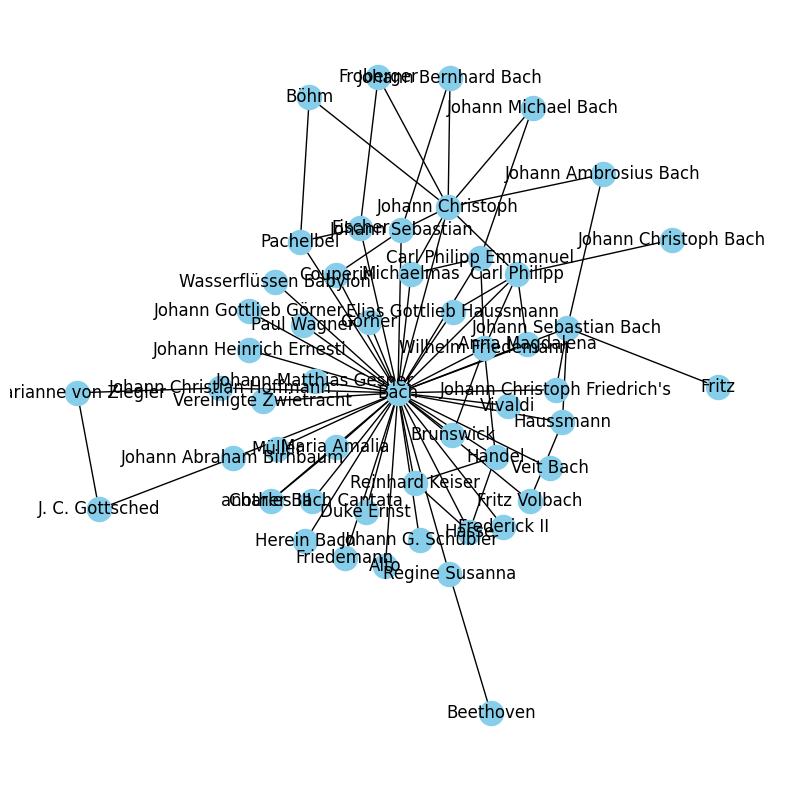

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, ax=ax, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

In [20]:
#!pip3 install pyvis
from pyvis.network import Network
net = Network(notebook=True, width='1000px', height='700px', bgcolor='#222222', font_color='white')

#node_degree = dict(G.degree)
#nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G, edge_scaling=True, show_edge_weights=True)
net.show('bach.html')

bach.html


## The most important character

In [21]:
degree_dict = nx.degree_centrality(G)
degree_dict

{'Bach': 0.803921568627451,
 'Veit Bach': 0.0196078431372549,
 'Johann Christoph Bach': 0.0196078431372549,
 'Carl Philipp': 0.11764705882352941,
 'Johann Christoph': 0.1764705882352941,
 'Michaelmas': 0.058823529411764705,
 'Carl Philipp Emmanuel': 0.0784313725490196,
 'Johann Michael Bach': 0.0392156862745098,
 'Johann Bernhard Bach': 0.0392156862745098,
 'Johann Sebastian': 0.0784313725490196,
 'Johann Sebastian Bach': 0.09803921568627451,
 'Johann Ambrosius Bach': 0.0392156862745098,
 'Froberger': 0.0392156862745098,
 'Fischer': 0.058823529411764705,
 'Pachelbel': 0.058823529411764705,
 'Böhm': 0.0392156862745098,
 'Handel': 0.0784313725490196,
 'Couperin': 0.0392156862745098,
 'Wasserflüssen Babylon': 0.0196078431372549,
 'Wilhelm Friedemann': 0.09803921568627451,
 'Johann Gottlieb Görner': 0.0196078431372549,
 'Görner': 0.0196078431372549,
 'Paul Wagner': 0.0196078431372549,
 'Anna Magdalena': 0.0392156862745098,
 'Johann Heinrich Ernesti': 0.0196078431372549,
 'Johann Matthias G

<Axes: >

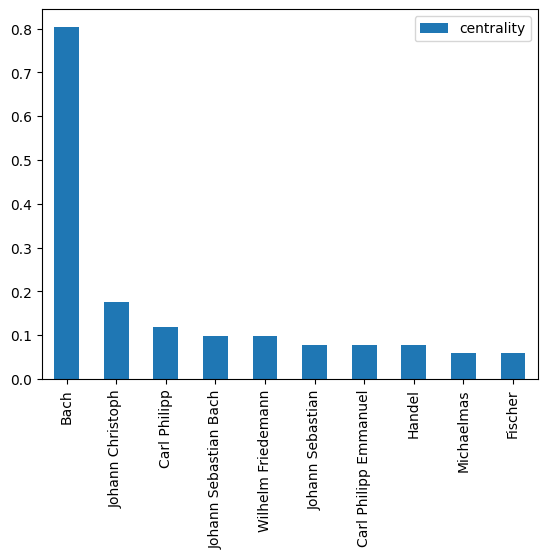

In [22]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
degree_df.sort_values('centrality', ascending=False)[:10].plot(kind='bar')

### Centralityで上位の人たちは誰？

Johann Christoph は Johann Sebastien の一番年上の兄。

```
In 1695, when Johann Sebastian was not quite ten years old, his father
died. He lost his mother at an earlier period.(47) So, being left an
orphan, he became dependent on his eldest brother, Johann Christoph,
Organist at Ohrdruf,(48) from whom he received his earliest lessons on the
Clavier.(49)
```

Wilhelm Friedemann は Johann Sebastien の１番年上の子供。
```
Bach and his eldest son, Wilhelm Friedemann.
```

Carl Philipp Emmanuel は Johann Sebastien の２番目に年上の子供。
```
His two eldest sons, Wilhelm Friedemann and Carl Philipp Emmanuel, were his most
distinguished pupils, not because he gave them better instruction than the
rest, but because from their earliest youth they were brought up amid good
music at home. 
```

Handelはバッハと同じ時代の有名なドイツ人音楽家でイギリスで成功。

<Axes: >

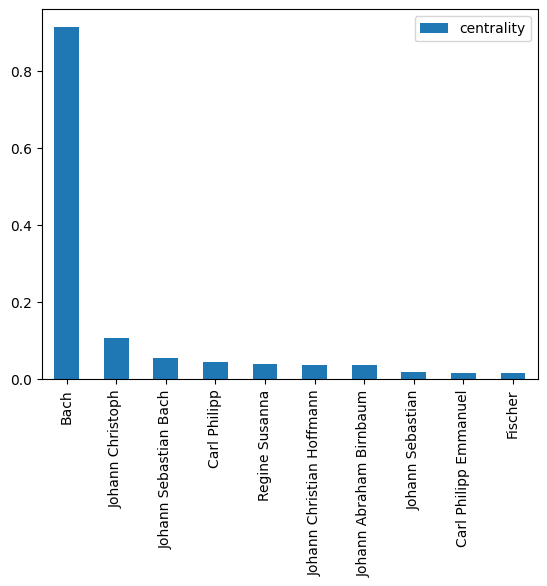

In [23]:
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
betweenness_df.sort_values('centrality', ascending=False)[:10].plot(kind='bar')

<Axes: >

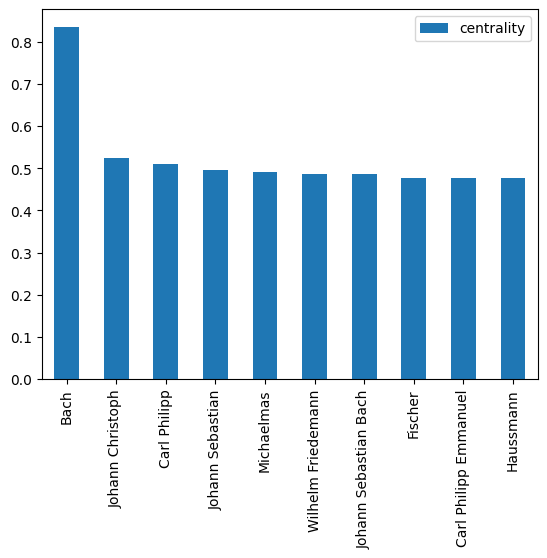

In [24]:
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
closeness_df.sort_values('centrality', ascending=False)[:10].plot(kind='bar')